In [34]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

Data PM 10 Preparation

In [35]:
# Load CSV
df_csv = pd.read_csv('/Users/Jia/Downloads/data_skripsi/PM_10/pm10_arrange.csv')

In [36]:
# Mengonversi kolom 'time' ke tipe data datetime
df_csv['time'] = pd.to_datetime(df_csv['time'])

# Menambahkan kolom 'month'
df_csv['month'] = df_csv['time'].dt.month

# Menambahkan kolom 'year'
df_csv['year'] = df_csv['time'].dt.year

# Melakukan group by bulan, longitude, dan latitude, dan menghitung rata-rata pm10
pm10_mean_monthly = df_csv.groupby(['month', 'year', 'longitude', 'latitude'], as_index=False)['pm10'].mean()

Optional

Menyimpan hasil ke file CSV #

df_csv.to_csv('/Users/Jia/Downloads/data_skripsi/PM_10/pm10_mean_month.csv', index=False)

Spatial Join df and gdf

In [37]:
# Load shapefile into a GeoDataFrame
gdf_shapefile = gpd.read_file(r"/Users/Jia/Downloads/data_skripsi/kota_DKIJakarta/Kota_DKIJakarta.shp")

In [38]:
# Convert DataFrame to GeoDataFrame
geometry = gpd.points_from_xy(df_csv['longitude'], df_csv['latitude'])
gdf_csv = gpd.GeoDataFrame(df_csv, geometry=geometry, crs="EPSG:4326")

<Axes: >

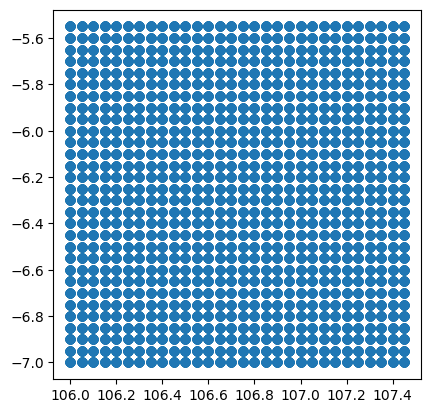

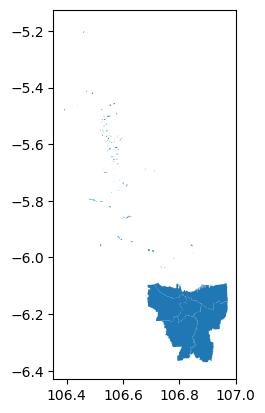

In [39]:
gdf_csv.plot()
gdf_shapefile.plot()

In [40]:
# spatial join
result = gpd.sjoin(gdf_csv, gdf_shapefile, how='inner', predicate='intersects')
result_pop = result[['longitude', 'latitude', 'pm10', 'month', 'year', 'KABKOT', 'geometry', 'time']]

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1440 entries, 406 to 53659
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   longitude  1440 non-null   float64       
 1   latitude   1440 non-null   float64       
 2   pm10       1440 non-null   float64       
 3   month      1440 non-null   int32         
 4   year       1440 non-null   int32         
 5   KABKOT     1440 non-null   object        
 6   geometry   1440 non-null   geometry      
 7   time       1440 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), geometry(1), int32(2), object(1)
memory usage: 90.0+ KB


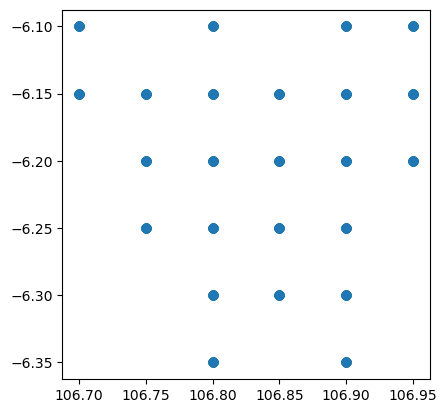

In [41]:
result_pop.plot()
result_pop.info()

Dissolved Result

In [42]:
# Dissolve berdasarkan 'KABKOT' 'month' 'year' dengan fungsi agregasi mean
dissolved_result = result_pop.dissolve(by=['KABKOT', 'month', 'year'], aggfunc='mean')

# Reset indeks untuk membuat kolom 'KABKOT' 'month' 'year' menjadi kolom
dissolved_result.reset_index(inplace=True)

In [43]:
# Tampilkan hasil
dissolved_result.head()

,KABKOT,month,year,geometry,longitude,latitude,pm10,time
0,JAKARTA BARAT,1,2018,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,47.294950,2018-01-01
1,JAKARTA BARAT,1,2019,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,56.890549,2019-01-01
2,JAKARTA BARAT,1,2020,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,56.164344,2020-01-01
3,JAKARTA BARAT,1,2021,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,55.754458,2021-01-01
4,JAKARTA BARAT,1,2022,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,57.999436,2022-01-01


In [44]:
dissolved_result_df = pd.DataFrame(dissolved_result)
dissolved_result_df = dissolved_result_df.drop(['geometry'], axis=1) #kolom geometry di hapus

In [45]:
#untuk mengurutkan file berdasarkan
dissolved_result_df = dissolved_result_df.sort_values(by=[ 'year', 'KABKOT', 'month'])

In [46]:
dissolved_result_df.to_csv("dissolved_result_pm10.csv") 

#di save ke csv, jadi data rata" bulanan

In [47]:
polygon_result = gpd.sjoin(gdf_shapefile, dissolved_result, how='inner', predicate='intersects')
polygon_result.rename(columns= {'KABKOT_left':'KABKOT', 'index_right':'index'}, inplace=True)
polygon_result.drop(columns={'KABKOT_right'}, inplace=True)

In [48]:
print(polygon_result.columns)

Index(['PROVNO', 'KABKOTNO', 'PROVINSI', 'KABKOT', 'geometry', 'index',
       'month', 'year', 'longitude', 'latitude', 'pm10', 'time'],
      dtype='object')


Grafik Timetrend Series

In [49]:
import calendar

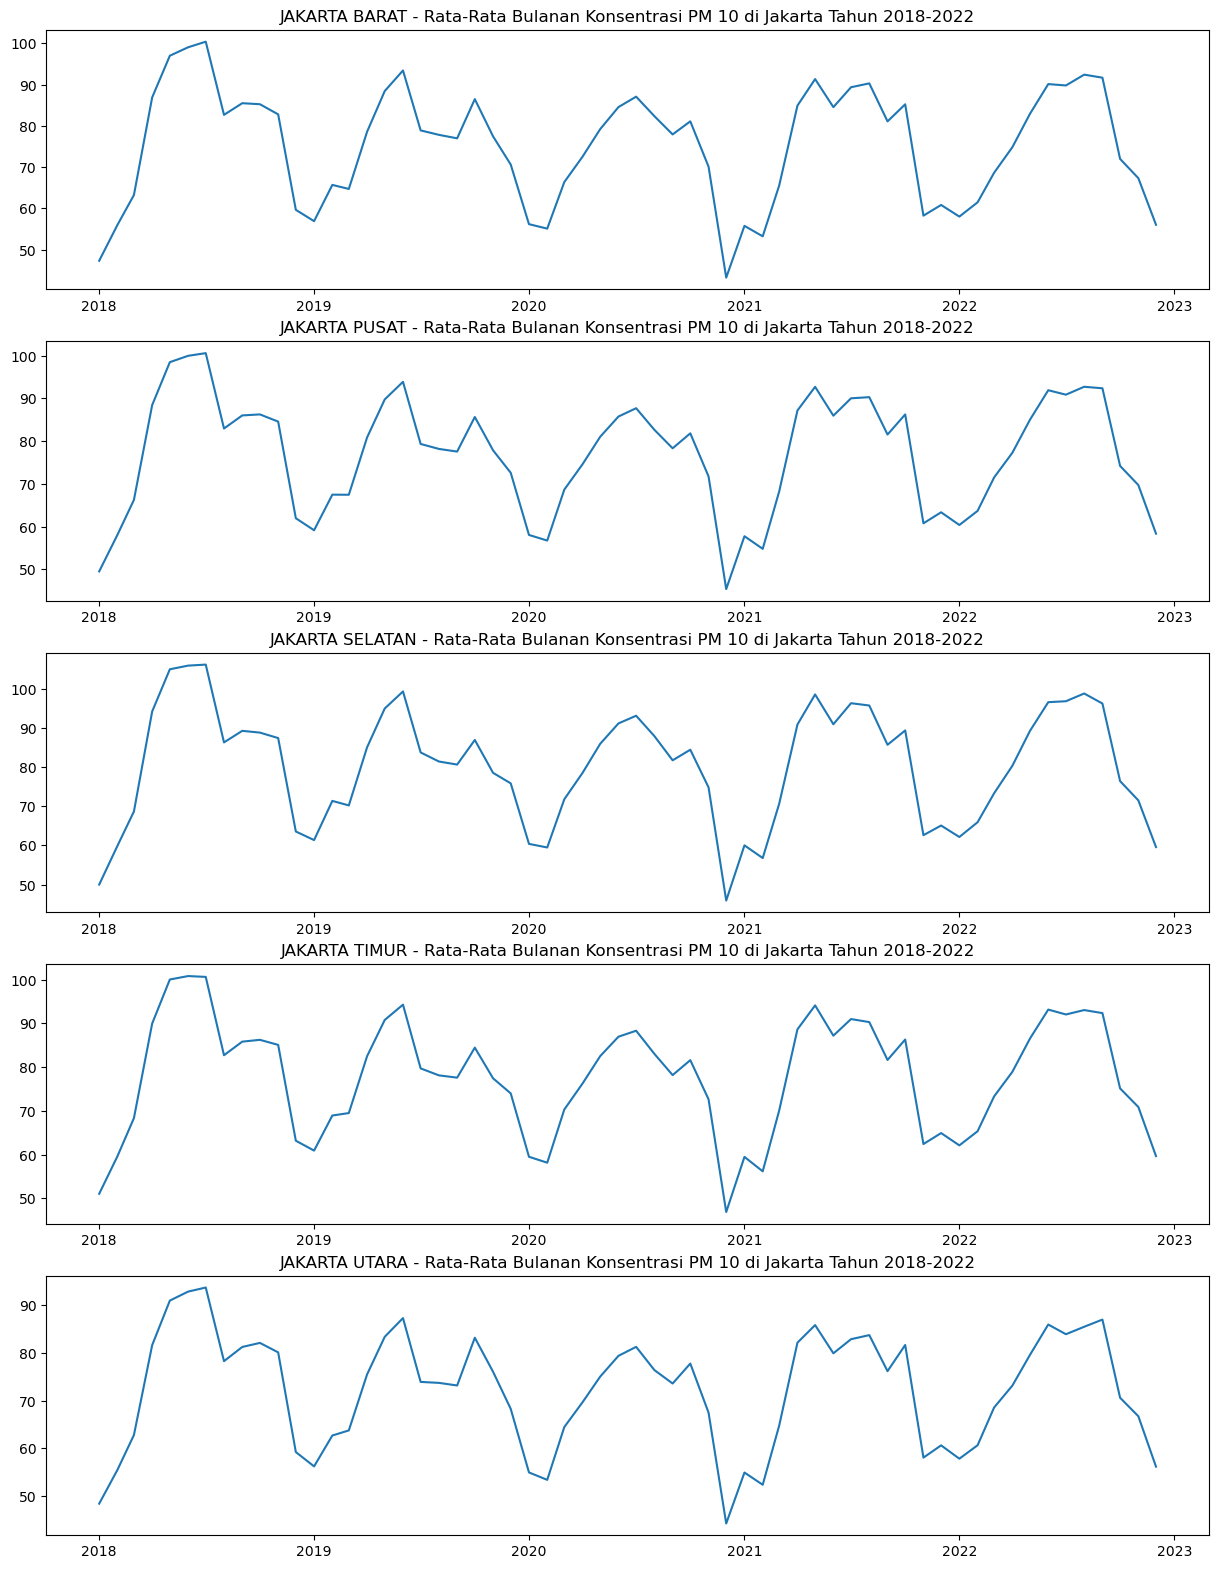

In [50]:
fig  = plt.figure(figsize=(15,60))
cities = list(dissolved_result_df['KABKOT'].unique())
dissolved_result_df = dissolved_result_df.set_index('time')

# Iterate through each month and plot the data
for city, ax in zip(cities, range(1,6)):
    # Filter data for the current wilayah admin
    data_city = dissolved_result_df[dissolved_result_df['KABKOT'] == city]

    # Plot the map for the current kabkot
    fig.add_subplot(15, 1, ax)
    plt.plot(data_city['pm10'])
    plt.title(f'{city} - Rata-Rata Bulanan Konsentrasi PM 10 di Jakarta Tahun 2018-2022')

Analisis Univariat

In [51]:
mean_pm10_month_year = dissolved_result.groupby(['year', 'month'], as_index=False)['pm10'].mean()

mean_pm10_month_year['pm10'] = mean_pm10_month_year['pm10'].round(2)

mean_pm10_month_year

,year,month,pm10
0,2018,1,49.24
1,2018,2,57.81
2,2018,3,65.85
3,2018,4,88.23
4,2018,5,98.29
5,2018,6,99.72
6,2018,7,100.30
7,2018,8,82.58
8,2018,9,85.57
9,2018,10,85.73


In [52]:
#mean_pm10_month_year.to_excel("/Users/Jia/Downloads/data_skripsi/PM_10/pm10_year_mean.xlsx")

In [53]:
# mean per tahun
pm10_year_mean = dissolved_result.groupby(['year'], as_index=False)['pm10'].mean()

pm10_year_mean['pm10'] = pm10_year_mean['pm10'].round(2)

pm10_year_mean

,year,pm10
0,2018,79.90
1,2019,77.17
2,2020,72.42
3,2021,76.28
4,2022,76.97


In [55]:
#nilai mean
pm10_mean_5years = mean_pm10_month_year ['pm10'].mean()
pm10_mean_5years

76.54783333333333

In [56]:
#nilai min
pm10_min_5years = mean_pm10_month_year ['pm10'].min()
pm10_min_5years

45.12

In [57]:
#nilai max
pm10_max_5years = mean_pm10_month_year ['pm10'].max()
pm10_max_5years

100.3

In [58]:
# nilai min and max per kabkot 5 tahun
monthly_total = dissolved_result_df.groupby(['KABKOT', 'month'], as_index=False)['pm10'].mean()

monthly_total['pm10'] = monthly_total['pm10'].round(2)

# Nilai minimum
min_row = monthly_total.loc[monthly_total['pm10'].idxmin()]
min_location = min_row['KABKOT']
min_month = min_row['month']
min_value = min_row['pm10']

# Nilai maksimum
max_row = monthly_total.loc[monthly_total['pm10'].idxmax()]
max_location = max_row['KABKOT']
max_month = max_row['month']
max_value = max_row['pm10']

# Menampilkan hasil
print(f"PM 10 min = {min_value}, {min_location}, {min_month}.")
print(f"PM 10 max = {max_value},{max_location}, {max_month}.")

PM 10 min = 54.46, JAKARTA UTARA, 1.
PM 10 max = 96.76,JAKARTA SELATAN, 6.


In [59]:
#mean kabkot 5 years

mean_kabkot = dissolved_result_df.groupby(['KABKOT'], as_index=False)['pm10'].mean()

mean_kabkot['pm10'] = mean_kabkot['pm10'].round(2)

mean_kabkot_sorted = mean_kabkot.sort_values(by='pm10', ascending=False)
print(mean_kabkot_sorted)

            KABKOT   pm10
2  JAKARTA SELATAN  80.31
3    JAKARTA TIMUR  77.84
1    JAKARTA PUSAT  76.85
0    JAKARTA BARAT  75.37
4    JAKARTA UTARA  72.36
